In [2]:
from sqlalchemy import create_engine
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from shapash.explainer.smart_explainer import SmartExplainer

#Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,plot_confusion_matrix

df = pd.read_csv('credit.csv', header=0) #Fetching clean data
pd.set_option('max_columns', None)

In [3]:
df = df.drop_duplicates()
num = df.iloc[:,11:23]._get_numeric_data()
num[num < 0] = 0    #getting rid of the negative values in Bills and Payments as well as any duplicates since they're useless for the purpose of modelling.

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


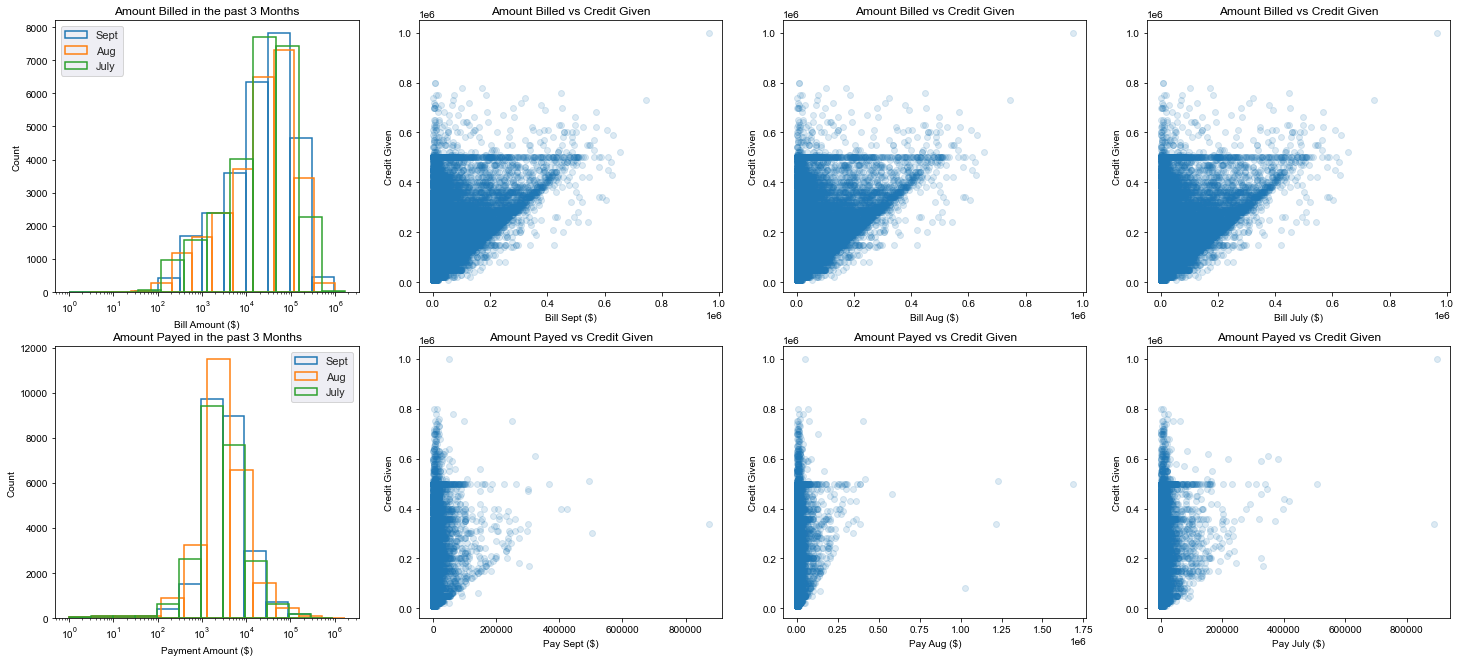

In [4]:
def EDA_Plots(df) :   #defining a function allows me to call back on it to generate the same graphs with different data frames, saving me time and coding space.
    fig, axes = plt.subplots(2,4,figsize = (25,11))

    x = df.loc[df.BILL_AMT1 > 0]
    x2 = df.loc[df.BILL_AMT2 > 0]
    x3 = df.loc[df.BILL_AMT3 > 0]
    x4 = df.loc[df.PAY_AMT1 > 0]
    x5 = df.loc[df.PAY_AMT2 > 0]
    x6 = df.loc[df.PAY_AMT3 > 0]

    sns.set_theme(style="darkgrid")
    
    #First Histogram
    sns.histplot(data=x, x=x["BILL_AMT1"], bins=12, log_scale=True, fill=False, label="Sept",ax=axes[0,0])
    sns.histplot(data=x2, x=x2["BILL_AMT2"], bins=12, log_scale=True, fill=False,label="Aug",ax=axes[0,0])
    sns.histplot(data=x3, x=x3["BILL_AMT3"], bins=12, log_scale=True, fill=False,label="July",ax=axes[0,0])
    axes[0,0].set_title("Amount Billed in the past 3 Months")
    axes[0,0].set_xlabel("Bill Amount ($)")
    axes[0,0].legend()
    
    #Second Histogram
    sns.histplot(data=x4, x=x4["PAY_AMT1"], bins=12, log_scale=True, fill=False, label="Sept",ax=axes[1,0])
    sns.histplot(data=x5, x=x5["PAY_AMT2"], bins=12, log_scale=True, fill=False,label="Aug",ax=axes[1,0])
    sns.histplot(data=x6, x=x6["PAY_AMT3"], bins=12, log_scale=True, fill=False,label="July",ax=axes[1,0])
    axes[1,0].set_title("Amount Payed in the past 3 Months")
    axes[1,0].set_xlabel("Payment Amount ($)")
    axes[1,0].legend()

    #Scatter Plots
    sns.regplot(data=x, x=x["BILL_AMT1"], y=x["LIMIT_BAL"],ax=axes[0,1],scatter_kws={'alpha':0.15},fit_reg=False)
    sns.regplot(data=x2, x=x2["BILL_AMT1"], y=x2["LIMIT_BAL"],ax=axes[0,2],scatter_kws={'alpha':0.15},fit_reg=False)
    sns.regplot(data=x3, x=x3["BILL_AMT1"], y=x3["LIMIT_BAL"],ax=axes[0,3],scatter_kws={'alpha':0.15},fit_reg=False)
    sns.regplot(data=x4, x=x4["PAY_AMT1"], y=x4["LIMIT_BAL"],ax=axes[1,1],scatter_kws={'alpha':0.15},fit_reg=False)
    sns.regplot(data=x5, x=x5["PAY_AMT2"], y=x5["LIMIT_BAL"],ax=axes[1,2],scatter_kws={'alpha':0.15},fit_reg=False)
    sns.regplot(data=x6, x=x6["PAY_AMT3"], y=x6["LIMIT_BAL"],ax=axes[1,3],scatter_kws={'alpha':0.15},fit_reg=False)
    
    axes[0,1].set_title("Amount Billed vs Credit Given")
    axes[0,1].set_xlabel("Bill Sept ($)")
    axes[0,1].set_ylabel("Credit Given")
    #axes[1].set(xscale='log', yscale='log')
    axes[0,2].set_title("Amount Billed vs Credit Given")
    axes[0,2].set_xlabel("Bill Aug ($)")
    axes[0,2].set_ylabel("Credit Given")
    
    axes[0,3].set_title("Amount Billed vs Credit Given")
    axes[0,3].set_xlabel("Bill July ($)")
    axes[0,3].set_ylabel("Credit Given")
    
    axes[1,1].set_title("Amount Payed vs Credit Given")
    axes[1,1].set_xlabel("Pay Sept ($)")
    axes[1,1].set_ylabel("Credit Given")
    
    axes[1,2].set_title("Amount Payed vs Credit Given")
    axes[1,2].set_xlabel("Pay Aug ($)")
    axes[1,2].set_ylabel("Credit Given")
    
    axes[1,3].set_title("Amount Payed vs Credit Given")
    axes[1,3].set_xlabel("Pay July ($)")
    axes[1,3].set_ylabel("Credit Given")
    
    
    
    #plt.show()
    
EDA_Plots(df)

Seems to me that something weird is happening with credit values of 500,000 dollars, for the last three bills it has multiple bill values corresponding to the same 500,000 credit value. 
This would hinder the accuracy of our model as it tries to correlate Bill Amount with Limit Balance. To avoid this, I will not take into credit score values around 500,000 and check weather my correlation improves.

In [5]:
drops = df[(df.LIMIT_BAL != 500000)]

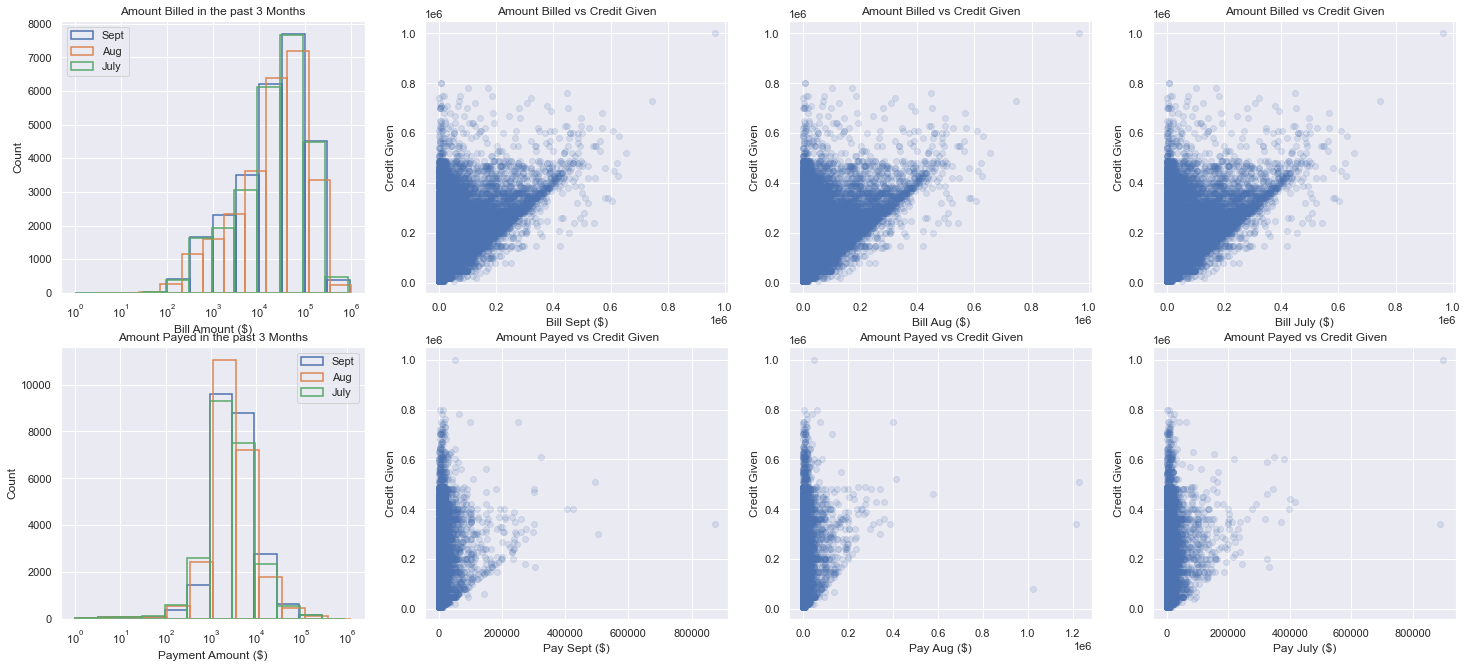

In [6]:
EDA_Plots(drops)

So this just dropped all values at 500,000 Credit taking it as outlayers, however it might not be the best way to do this.

In [7]:
drops.shape

(29244, 24)

In [8]:
#playing around with different regression plot that could be usefull in the future
#sns.lmplot(data=drops, y='LIMIT_BAL', x='BILL_AMT1', hue='EDUCATION',scatter_kws={'alpha':0.15},fit_reg=True)

In [9]:
"""
y = df.LIMIT_BAL
X = df[df.columns.difference(['LIMIT_BAL'])]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)
df[df.columns.difference(['LIMIT_BAL'])]
"""

"\ny = df.LIMIT_BAL\nX = df[df.columns.difference(['LIMIT_BAL'])]\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)\n\nfrom sklearn.ensemble import IsolationForest\n\niso = IsolationForest(contamination=0.1)\nyhat = iso.fit_predict(X_train)\ndf[df.columns.difference(['LIMIT_BAL'])]\n"

In [10]:
"""
mask = yhat != -1
X_train, y_train = X_train[mask, :], y_train[mask]
"""

'\nmask = yhat != -1\nX_train, y_train = X_train[mask, :], y_train[mask]\n'

(1, 10000000)

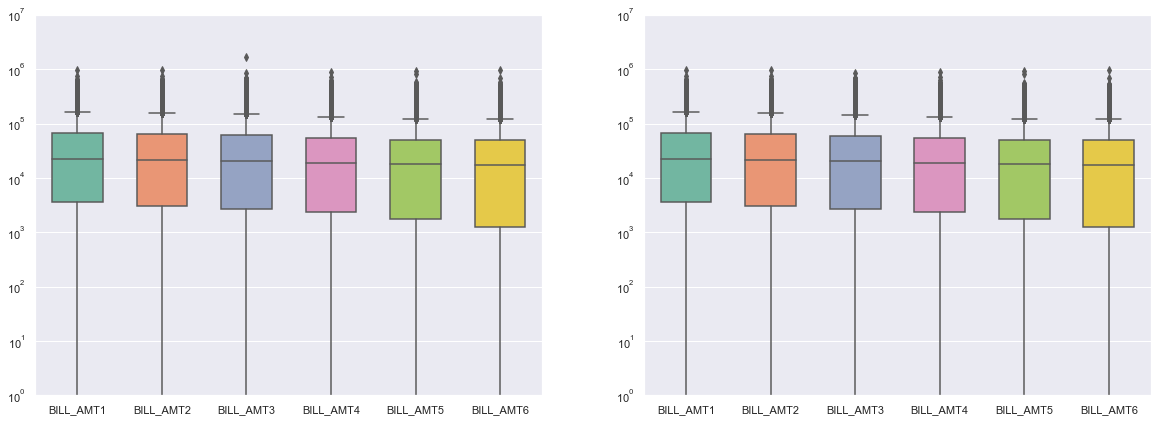

In [11]:
Bills = df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']]
Bills2 = drops[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']]
fig, ax = plt.subplots(1,2,figsize = (20,7))
sns.boxplot(data=Bills, width=0.6, ax=ax[0],palette="Set2",)
sns.boxplot(data=Bills2, width=0.6, ax=ax[1],palette="Set2",)
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_ylim(1,10000000)
ax[1].set_ylim(1,10000000)



Note that the box plots are in log scale, meaning their IQR spans a plethora of values. Also, the multiple points above the maximum line of the box plot shows the possibility of many anomalies in the data, more data cleaning must be done. 

In [12]:
Q1 = num.quantile(0.25)
Q3 = num.quantile(0.75)
IQR = Q3 - Q1
IQR_clean = num[(num > (Q1 - 1.5 * IQR)) & (num < (Q3 + 1.5 * IQR))]
IQR_clean = IQR_clean.dropna()

In [13]:
IQR_clean

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
5,64400.0,57069.0,57608.0,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0
...,...,...,...,...,...,...,...,...,...,...,...,...
30192,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,0.0,0.0,0.0,0.0,0.0,0.0
30193,8802.0,10400.0,0.0,0.0,0.0,0.0,2000.0,0.0,0.0,0.0,0.0,0.0
30195,72557.0,77708.0,79384.0,77519.0,82607.0,81158.0,7000.0,3500.0,0.0,7000.0,0.0,4000.0
30197,1683.0,1828.0,3502.0,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0


In [14]:
CatData = df[['LIMIT_BAL','SEX','EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default payment next month']]
New_data =  CatData.merge(IQR_clean, right_index = True, left_index = True)
New_data

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,default payment next month,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,0,3,1,24,2,2,-1,-1,-2,-2,0,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,120000,0,3,2,26,-1,2,0,0,0,2,0,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,90000,0,3,2,34,0,0,0,0,0,0,1,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,50000,0,3,1,37,0,0,0,0,0,0,1,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
5,50000,1,0,2,37,0,0,0,0,0,0,1,64400.0,57069.0,57608.0,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30192,210000,1,3,1,34,3,2,2,2,2,2,0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,0.0,0.0,0.0,0.0,0.0,0.0
30193,10000,1,1,1,43,0,0,0,-2,-2,-2,1,8802.0,10400.0,0.0,0.0,0.0,0.0,2000.0,0.0,0.0,0.0,0.0,0.0
30195,80000,1,3,2,34,2,2,2,2,2,2,0,72557.0,77708.0,79384.0,77519.0,82607.0,81158.0,7000.0,3500.0,0.0,7000.0,0.0,4000.0
30197,150000,1,1,2,43,-1,-1,-1,-1,0,0,1,1683.0,1828.0,3502.0,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0


In [15]:
df.shape

(29965, 24)

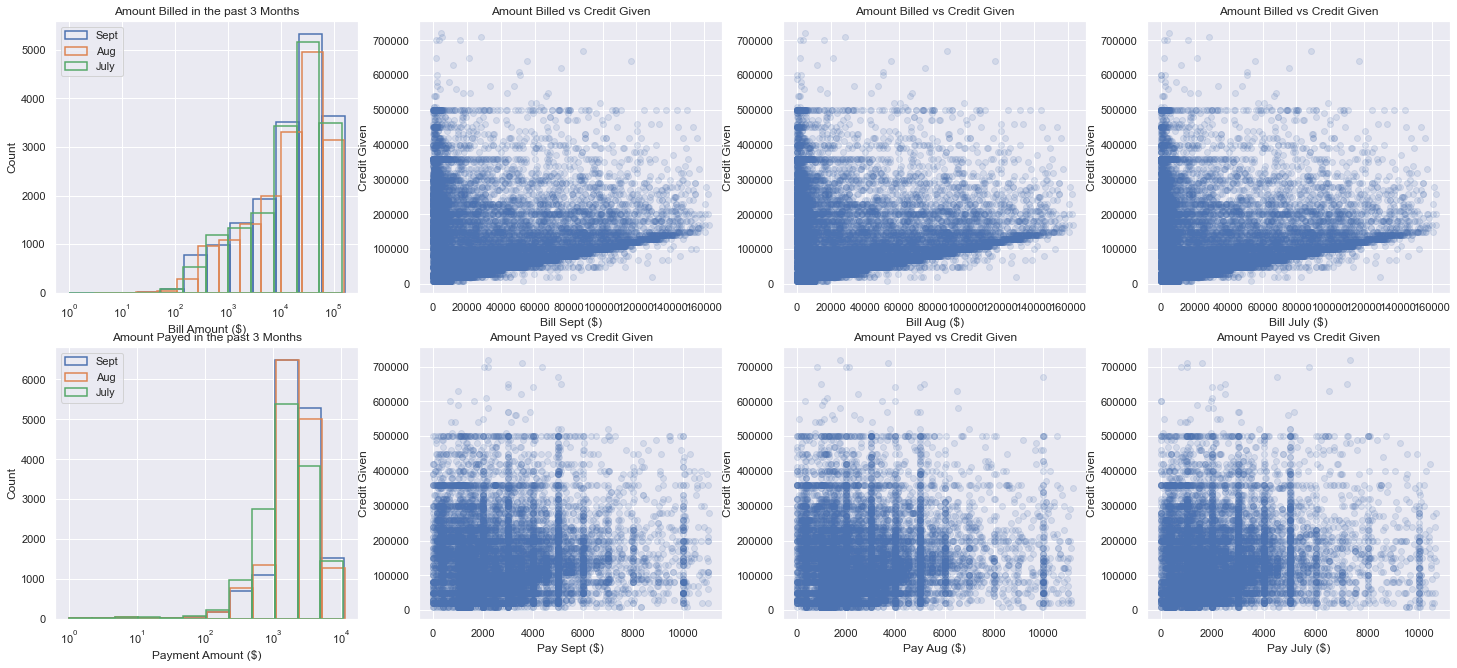

In [16]:
EDA_Plots(New_data)

Experiment of trying to use the IQR method to detect and remove outliers failed. Nearly a third of the data was removed and the graphs look even more random than before. It is my profesional opinion that the best course of action is to remove the data from the 500,000 credit score and continue with the RadomForest algorithm to generate an accurate model to predict whether a customer will default or not, and how much credit to give a new customer.

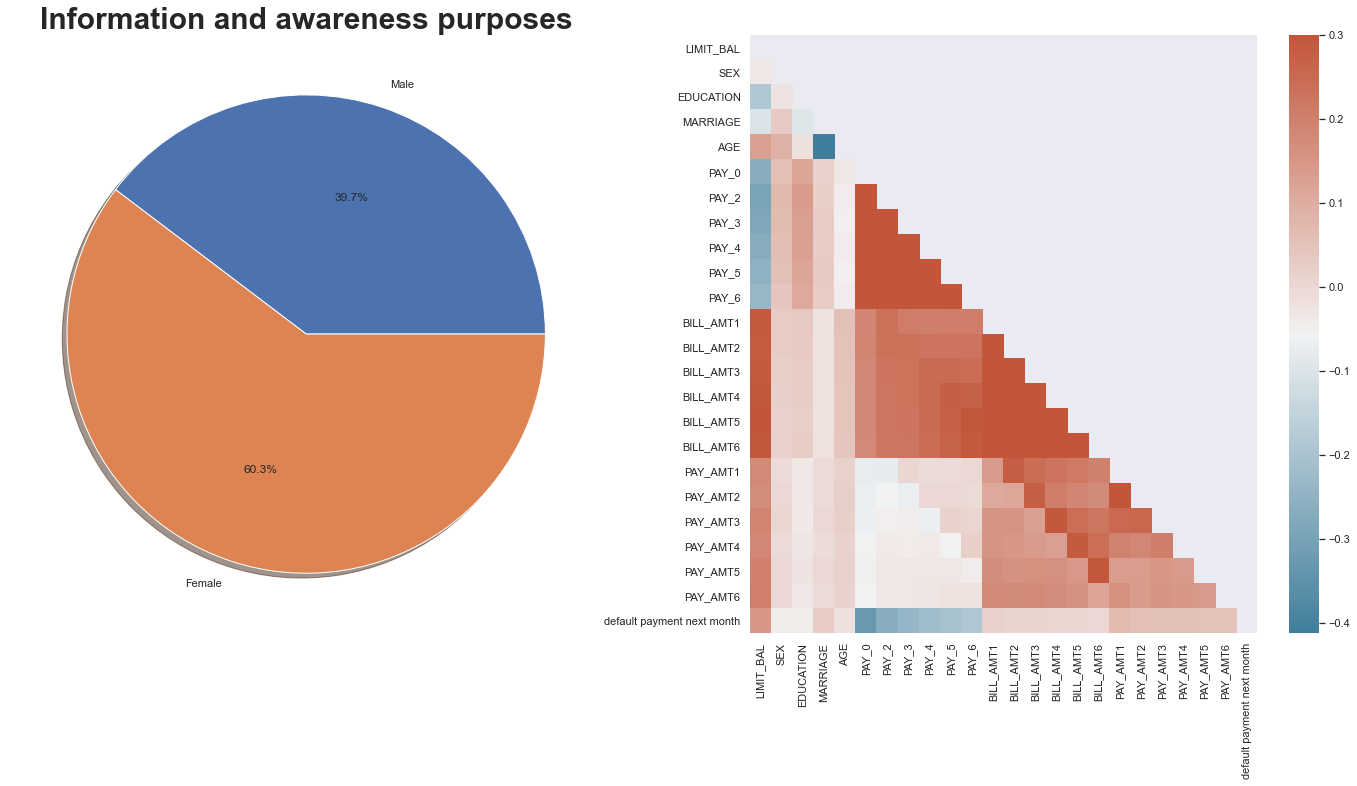

In [17]:
corr = drops.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
cmap = sns. diverging_palette(230,20, as_cmap=True)

fig, axes = plt.subplots(1,2,figsize = (25,11))
values = [11984, 18217]
my_labels = 'Male', 'Female'
axes[0].pie(values, labels = my_labels, autopct='%1.1f%%', shadow=True)
axes[0].set_title('Information and awareness purposes', fontweight='bold', fontsize = 30)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, ax = axes[1])

plt.show()

Using information from pandas.profiling I was able to construct these two graphs that seemed interesting to me. First of all, it is clear that there are more females than males and therefore i need to be careful when constructing my model to not be biased towards females. Furthermore, using the correlation heatmap, it is clear to see some strong correlation between Bill Amounts for past months and Payment Status, however it is not as clean cut for correlating any feature to the default status of a customer. This is why machine learning and modelling is vital for this task. 

I could continue to perfom EDAs to get a feel of the data, but i believe modelling is a good next step after this brief analysis and overview of the data.

## Beyond this point is machine modelling using Random Forest Calissfier and testing for accuracy (More of this will be covered later in task 3)

In [18]:
y = drops['default payment next month']
X = drops[drops.columns.difference(['default payment next month','LIMIT_BAL'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

rfc = RandomForestClassifier(n_estimators=300, n_jobs=2, random_state=0)   #.values gives the values in an array of shape (n,1)
default_model = rfc.fit(X_train, y_train.values.ravel())
default_pred = default_model.predict(X_test)

In [19]:
print("Accuracy = ", metrics.accuracy_score(y_test, default_pred))

#The code below will give me the contribution of each feature towards the accuracy of the model

#feature_list = list(X.columns)
#feature_imp = pd.Series(default_model.feature_importances_, index=feature_list).sort_values(ascending=False)
#feature_imp

Accuracy =  0.808856214737562


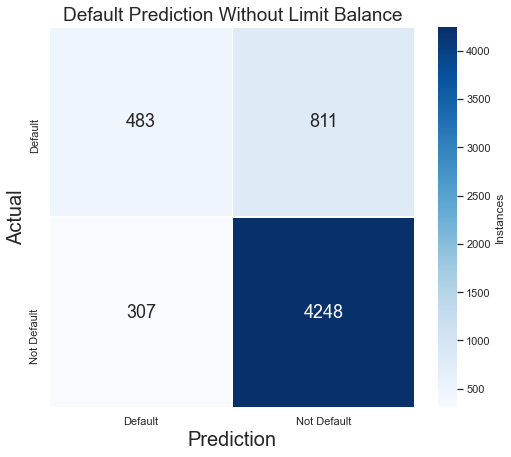

In [20]:
cm1 =confusion_matrix(y_test, default_pred)

df_cm1 = pd.DataFrame(cm1, range(2), range(2))

Amount=['Default', 'Not Default']

fig = plt.figure(figsize = (18,7)) # width x height
ax1 = fig.add_subplot(1, 2, 1) # row, column, position
#fig.subplots_adjust(hspace=0.45,wspace=0.45)


sns.heatmap(df_cm1, ax=ax1, xticklabels=Amount, yticklabels=Amount, annot=True,fmt="d", annot_kws={"size": 18},cmap="Blues",linewidths=.5,cbar_kws={'label': 'Instances'}) # font size
#sns.heatmap(df_cm2, ax=ax2, xticklabels=Amount, yticklabels=Amount, annot=True,fmt="d", annot_kws={"size": 18},cmap="Blues",linewidths=.5,cbar_kws={'label': 'Instances'}) # font size


ax1.set_xlabel('Predicted',fontsize=20)
ax1.set_ylabel('Actual',fontsize=20)
#ax2.set_xlabel('Predicted',fontsize=20)
#ax2.set_ylabel('Actual',fontsize=20)
#plt.suptitle('Default Prediction',fontsize=25)

ax1.set(xlabel='Prediction', ylabel='Actual')
ax1.set_title('Default Prediction Without Limit Balance', y=1, fontsize=19)
#ax2.set(xlabel='Prediction', ylabel='Actual')
#ax2.set_title('Not Default', y=2, fontsize=19)


plt.show()


Accuracy did not increase after taking out the $500,000 credit line, however I will try to see if i get a better accuracy predicting for the limit balance 

In [21]:
only_not_default = drops[(drops['default payment next month'] != 1)]
only_default = drops[(drops['default payment next month'] != 0)]

amount_default = pd.qcut(only_default['LIMIT_BAL'], q=5,labels=[0,1,2,3,4])
amount_not_default = pd.qcut(only_not_default['LIMIT_BAL'], q=5,labels=[0,1,2,3,4])

amount_default.head()

pd.qcut(drops['LIMIT_BAL'], q=5, precision=0)

y = amount_default
y2 = amount_not_default
X = only_default[only_default.columns.difference(['LIMIT_BAL'])]
X2 = only_not_default[only_not_default.columns.difference(['LIMIT_BAL'])]

X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.20, random_state=123)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=123)

In [22]:
rfc = RandomForestClassifier(n_estimators=200, n_jobs=2, random_state=0)   #.values gives the values in an array of shape (n,1)
default_model = rfc.fit(X1_train, y1_train.values.ravel())     #.ravel() converts array to shape (n,)
not_default_model = rfc.fit(X2_train, y2_train.values.ravel())

default_pred = default_model.predict(X1_test)
not_default_pred = not_default_model.predict(X2_test)

In [23]:
print("Accuracy = ", metrics.accuracy_score(y1_test, default_pred))

#feature_list = list(X.columns)
#feature_imp = pd.Series(default_model.feature_importances_, index=feature_list).sort_values(ascending=False)
#feature_imp

Accuracy =  0.36814276272306673


In [24]:
print("Accuracy = ", metrics.accuracy_score(y2_test, not_default_pred))

#feature_list = list(X.columns)
#feature_imp = pd.Series(not_default_model.feature_importances_, index=feature_list).sort_values(ascending=False)
#feature_imp

Accuracy =  0.6038167938931298


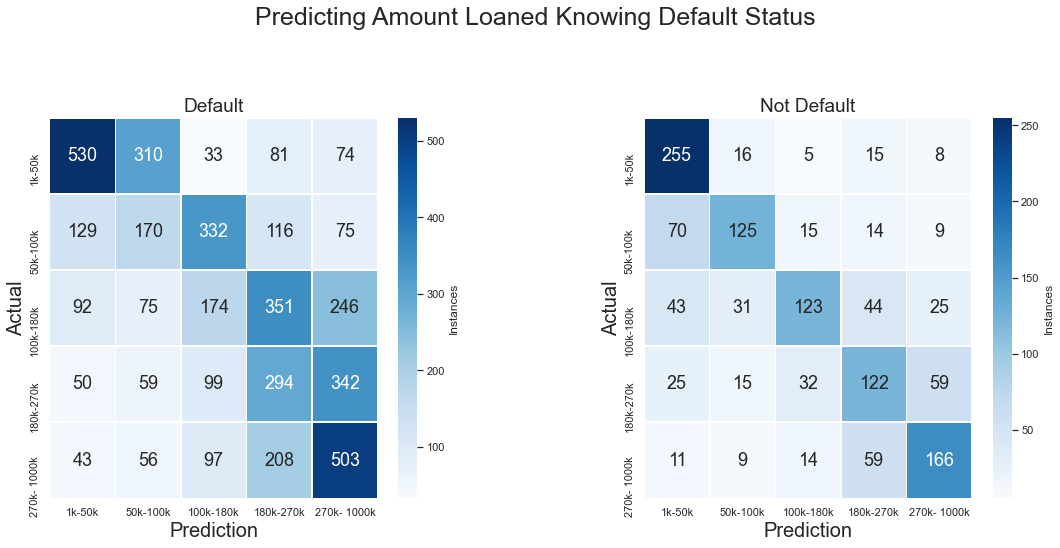

In [25]:
cm1 =confusion_matrix(y1_test, default_pred)
cm2 =confusion_matrix(y2_test, not_default_pred)

df_cm1 = pd.DataFrame(cm1, range(5), range(5))
df_cm2 = pd.DataFrame(cm2, range(5), range(5))

Amount=['1k-50k', '50k-100k', '100k-180k', '180k-270k', '270k- 1000k']

fig = plt.figure(figsize = (18,7)) # width x height
ax1 = fig.add_subplot(1, 2, 1) # row, column, position
ax2 = fig.add_subplot(1, 2, 2)
fig.subplots_adjust(hspace=0.45,wspace=0.45)


sns.heatmap(df_cm1, ax=ax1, xticklabels=Amount, yticklabels=Amount, annot=True,fmt="d", annot_kws={"size": 18},cmap="Blues",linewidths=.5,cbar_kws={'label': 'Instances'}) # font size
sns.heatmap(df_cm2, ax=ax2, xticklabels=Amount, yticklabels=Amount, annot=True,fmt="d", annot_kws={"size": 18},cmap="Blues",linewidths=.5,cbar_kws={'label': 'Instances'}) # font size


ax1.set_xlabel('Predicted',fontsize=20)
ax1.set_ylabel('Actual',fontsize=20)
ax2.set_xlabel('Predicted',fontsize=20)
ax2.set_ylabel('Actual',fontsize=20)
plt.suptitle('Predicting Amount Loaned Knowing Default Status',fontsize=25,y=1.1)

ax1.set(xlabel='Prediction', ylabel='Actual')
ax1.set_title('Default', y=1, fontsize=19)
ax2.set(xlabel='Prediction', ylabel='Actual')
ax2.set_title('Not Default', y=1, fontsize=19)


plt.show()


[Text(0.5, 0, 'Bill Sept'), Text(0, 0.5, 'Limit Balance')]

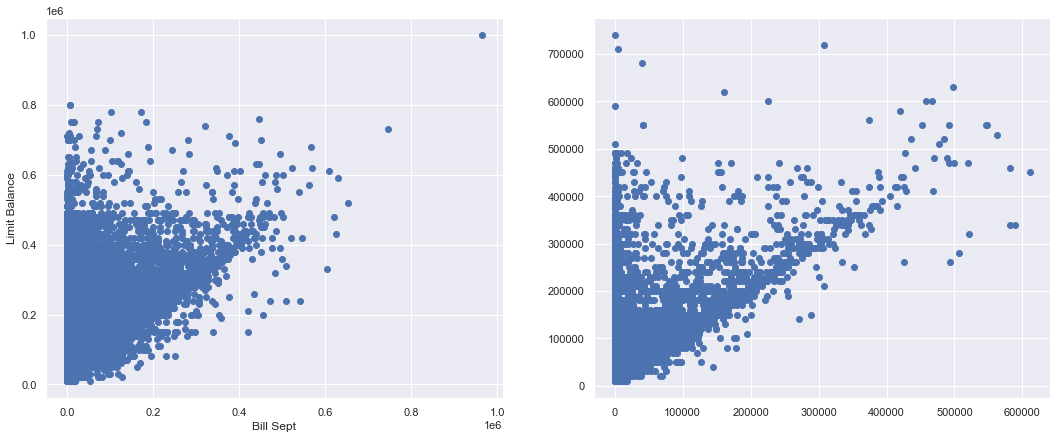

In [26]:
fig = plt.figure(figsize = (18,7))
ax1 = fig.add_subplot(1, 2, 1) # row, column, position
ax2 = fig.add_subplot(1, 2, 2)
ax1.scatter(X['BILL_AMT1'],only_default['LIMIT_BAL'])
ax2.scatter(X2['BILL_AMT1'],only_not_default['LIMIT_BAL'])
ax1.set(xlabel='Bill Sept', ylabel='Limit Balance')


In [27]:
drops.to_csv('drops.csv', index=False )